In [2]:
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from sklearn.cluster import KMeans
import numpy as np

In [3]:
df = pd.read_csv("customer_dataset.csv")

/tmp/ipykernel_33/3578765535.py:1: DtypeWarning: Columns (1,2) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv("/kaggle/input/customer_dataset.csv")


In [4]:
df.columns

Index(['customer_id', 'average_monthly_spend',
       'average_monthly_visit_frequency', 'average_monthly_basket_size'],
      dtype='object')

# Data cleaning

* ### Identify the Datatype

In [5]:
df.dtypes

customer_id                          int64
average_monthly_spend               object
average_monthly_visit_frequency     object
average_monthly_basket_size        float64
dtype: object

* ### Remove the duplicate values

In [6]:
df = df.drop_duplicates()

* ### Get the count of null values in every column

In [7]:
df.isnull().sum()

customer_id                           0
average_monthly_spend              9386
average_monthly_visit_frequency    9328
average_monthly_basket_size        9286
dtype: int64

In [8]:
len(df)

566947

In [9]:
df

,customer_id,average_monthly_spend,average_monthly_visit_frequency,average_monthly_basket_size
0,1,790,1.11,2.84
1,2,176875,15.74,33.83
2,3,6812,2.11,NaN
3,4,38542,7.82,10.73
4,5,48712,7.51,10.04
...,...,...,...,...
569991,234632,89150.0,10.87,38.31
569996,215276,141241.0,15.47,31.13
569997,11515,9183.0,2.09,4.61
569998,205260,35541.0,4.22,9.65


### Frequnecy mapping
* Here some values filled by the sentences(text) so we did the frequency mapping for that

In [10]:
freequency_mapping = {
    'one point two': 1.2,
    'nine point five': 9.5,
    'two': 2,
    'twenty two': 22,
    'three point four': 3.4
}

df['average_monthly_visit_frequency'] = df['average_monthly_visit_frequency'].replace(freequency_mapping)

In [11]:
def is_not_numeric(value):
    try:
        float(value)
        return False
    except ValueError:
        return True

mask = df[['average_monthly_spend', 'average_monthly_visit_frequency', 'average_monthly_basket_size']].applymap(is_not_numeric)

non_numeric_rows = df[mask.any(axis=1)]
print(non_numeric_rows)

/tmp/ipykernel_33/3839936412.py:8: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  mask = df[['average_monthly_spend', 'average_monthly_visit_frequency', 'average_monthly_basket_size']].applymap(is_not_numeric)


    customer_id average_monthly_spend average_monthly_visit_frequency  \
26           27          nine hundred                             1.9   

    average_monthly_basket_size  
26                         1.24  


In [12]:
spend_mapping = {
    'nine hundred': 900,
}

df['average_monthly_spend'] = df['average_monthly_spend'].replace(spend_mapping)

In [13]:
df['average_monthly_spend'] = df['average_monthly_spend'].astype(float)
df['average_monthly_visit_frequency'] = df['average_monthly_visit_frequency'].astype(float)

### Handle the negative value by changing that to absolute value

In [14]:
df = df.abs()

In [15]:
if (df['average_monthly_spend'] < 0).any():
    print("There are negative values in the 'average_monthly_visit_frequency' column.")
else:
    print("There are no negative values in the 'average_monthly_visit_frequency' column.")

There are no negative values in the 'average_monthly_visit_frequency' column.


### Correaltion 

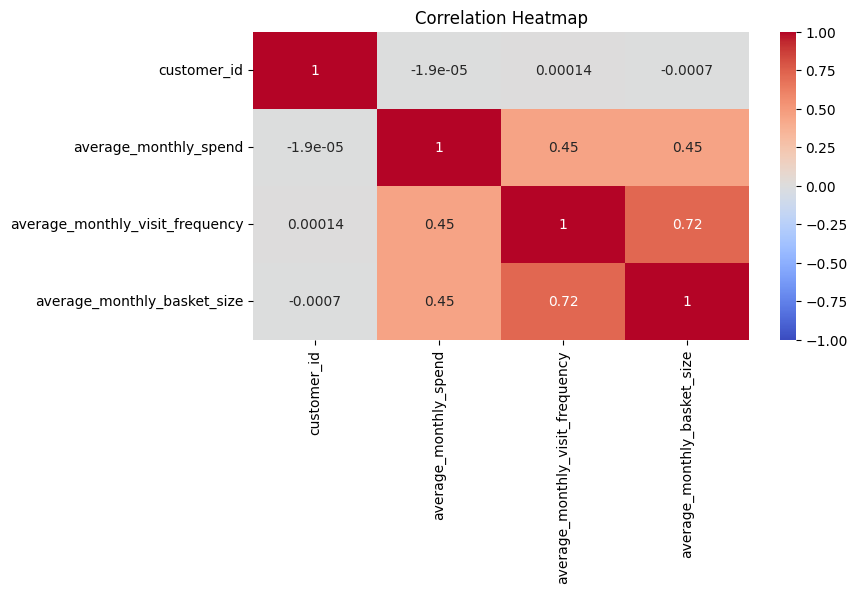

In [16]:
correlation_matrix = df.corr()
plt.figure(figsize=(8, 4))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', vmin=-1, vmax=1)
plt.title('Correlation Heatmap')
plt.show()

### Scatter plot of data points
* (average_monthly_visit_frequency VS average_monthly_basket_size)

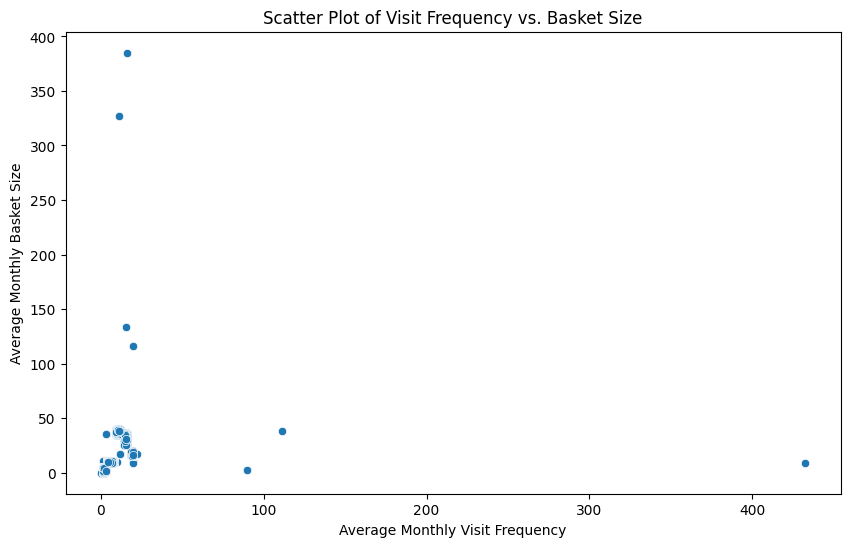

In [17]:
plt.figure(figsize=(10, 6))
sns.scatterplot(x='average_monthly_visit_frequency', y='average_monthly_basket_size', data=df)

plt.xlabel('Average Monthly Visit Frequency')
plt.ylabel('Average Monthly Basket Size')
plt.title('Scatter Plot of Visit Frequency vs. Basket Size')

plt.show()

### Fill the nan values in every column

* For this case separate as 4 data frames 
  * train = Contain the not null value rows 
  
  * test_1 = Which rows are contain the null value of average_monthly_spend
  
  * test_2 = Which rows are contain the null value of average_monthly_visit_frequency
  
  * test_3 = Which rows are contain the null value of average_monthly_basket_size


* To fill those value we used the linear regression model to predict the nan values

In [19]:
train = df[df['average_monthly_spend'].notnull() & df['average_monthly_visit_frequency'].notnull() & df['average_monthly_basket_size'].notnull()]
test_1 = df[df['average_monthly_spend'].isnull()]
test_2 = df[df['average_monthly_visit_frequency'].isnull()]
test_3 = df[df['average_monthly_basket_size'].isnull()]

### Scaling the valuse using MinMaxScaler before input to the model to predict he nan values

In [20]:
features_ = ['average_monthly_spend', 'average_monthly_visit_frequency', 'average_monthly_basket_size']

# Initialize MinMaxScaler
scaler = MinMaxScaler()

# Fit the scaler on the training data and transform the training data
train_scaled = train.copy()
train_scaled[features_] = scaler.fit_transform(train[features_])

# Transform the test sets using the same scaler fitted on the training data
test_1_scaled = test_1.copy()
test_1_scaled[features_] = scaler.transform(test_1[features_].fillna(0))

test_2_scaled = test_2.copy()
test_2_scaled[features_] = scaler.transform(test_2[features_].fillna(0))

test_3_scaled = test_3.copy()
test_3_scaled[features_] = scaler.transform(test_3[features_].fillna(0))

In [21]:
features = ['average_monthly_visit_frequency', 'average_monthly_basket_size']
X_train = train_scaled[features]
X_test_1 = test_1_scaled[features]
y_train_1 = train_scaled['average_monthly_spend']

linear_reg = LinearRegression()
linear_reg.fit(X_train, y_train_1)
predictions_1 = linear_reg.predict(X_test_1)

test_1_scaled['average_monthly_spend'] = pd.Series(predictions_1, index=X_test_1.index)
combined_df = pd.concat([train_scaled, test_1_scaled], ignore_index=True)

In [22]:
features = ['average_monthly_spend', 'average_monthly_basket_size']
X_train = train_scaled[features]
X_test_2 = test_2_scaled[features]
y_train_2 = train_scaled['average_monthly_visit_frequency']

linear_reg = LinearRegression()
linear_reg.fit(X_train, y_train_2)
predictions_2 = linear_reg.predict(X_test_2)

test_2_scaled['average_monthly_visit_frequency'] = pd.Series(predictions_2, index=X_test_2.index)
combined_df_2 = pd.concat([combined_df, test_2_scaled], ignore_index=True)

In [23]:
features = ['average_monthly_visit_frequency', 'average_monthly_spend']
X_train = train_scaled[features]
X_test_3 = test_3_scaled[features]
y_train_3 = train_scaled['average_monthly_basket_size']

linear_reg = LinearRegression()
linear_reg.fit(X_train, y_train_3)
predictions_3 = linear_reg.predict(X_test_3)

test_3_scaled['average_monthly_basket_size'] = pd.Series(predictions_3, index=X_test_3.index)
df_cleaned = pd.concat([combined_df_2, test_3_scaled], ignore_index=True)

In [24]:
len(df_cleaned)

566947

### Inverse transform

In [25]:
scaler.fit(train[features_])  
df_cleaned[features_] = scaler.inverse_transform(df_cleaned[features_])

In [28]:
df_cleaned

,customer_id,average_monthly_spend,average_monthly_visit_frequency,average_monthly_basket_size
0,1,790.0,1.11,2.840000
1,2,176875.0,15.74,33.830000
2,4,38542.0,7.82,10.730000
3,5,48712.0,7.51,10.040000
4,6,172333.0,14.16,35.060000
...,...,...,...,...
566942,559883,7287.0,1.93,5.180726
566943,559887,12614.0,2.70,6.421350
566944,559946,49533.0,5.87,11.835930
566945,559971,95444.0,19.85,33.319614


In [29]:
df_cleaned.isnull().sum()

customer_id                        0
average_monthly_spend              0
average_monthly_visit_frequency    0
average_monthly_basket_size        0
dtype: int64

In [30]:
if (df_cleaned['average_monthly_spend'] < 0).any():
    print("There are negative values in the 'average_monthly_visit_frequency' column.")
else:
    print("There are no negative values in the 'average_monthly_visit_frequency' column.")

There are negative values in the 'average_monthly_visit_frequency' column.


In [31]:
df_no_negatives = df_cleaned[(df_cleaned >= 0).all(axis=1)]
print("\nDataFrame without negative values:")
print(df_no_negatives)


DataFrame without negative values:
        customer_id  average_monthly_spend  average_monthly_visit_frequency  \
0                 1                  790.0                             1.11   
1                 2               176875.0                            15.74   
2                 4                38542.0                             7.82   
3                 5                48712.0                             7.51   
4                 6               172333.0                            14.16   
...             ...                    ...                              ...   
566942       559883                 7287.0                             1.93   
566943       559887                12614.0                             2.70   
566944       559946                49533.0                             5.87   
566945       559971                95444.0                            19.85   
566946       559973                13981.0                             2.74   

        average

### Remove the outlier value 

In [32]:
import pandas as pd

# Assuming 'df_scaled' is your DataFrame with the provided data

# Function to remove outliers using the IQR method
def remove_outliers_iqr(df, column):
    Q1 = df[column].quantile(0.1)
    Q3 = df[column].quantile(0.9)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    df_no_outliers = df[(df[column] >= lower_bound) & (df[column] <= upper_bound)]
    count_outliers = df.shape[0] - df_no_outliers.shape[0]
    return df_no_outliers, count_outliers

# Apply the function to remove outliers for each numerical column
outlier_counts = {}
columns_to_check = ['average_monthly_spend', 'average_monthly_visit_frequency', 'average_monthly_basket_size']
for col in columns_to_check:
    df_no_negatives, outlier_count = remove_outliers_iqr(df_no_negatives, col)
    outlier_counts[col] = outlier_count

# Now 'df_scaled' contains your dataset with outliers removed
# 'outlier_counts' contains the count of outliers removed for each column
print("Outlier counts:")
for col, count in outlier_counts.items():
    print(f"{col}: {count}")


Outlier counts:
average_monthly_spend: 8
average_monthly_visit_frequency: 3
average_monthly_basket_size: 4


## Visualize the data values in 3d Plot

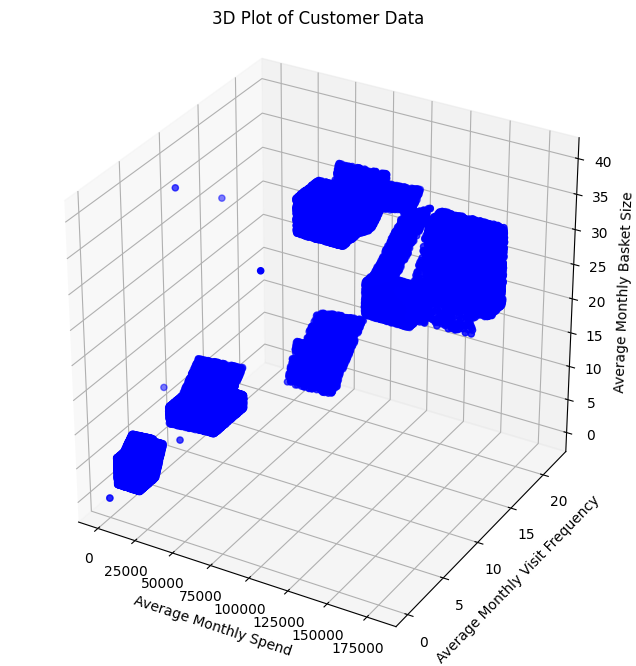

In [33]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

# Assuming 'df_scaled' is your DataFrame with the provided data

# Extracting data
customer_id = df_no_negatives['customer_id']
x = df_no_negatives['average_monthly_spend']
y = df_no_negatives['average_monthly_visit_frequency']
z = df_no_negatives['average_monthly_basket_size']

# Create a 3D plot
fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')

# Plotting
scatter = ax.scatter(x, y, z, c='b', marker='o')

# Set labels and title
ax.set_xlabel('Average Monthly Spend')
ax.set_ylabel('Average Monthly Visit Frequency')
ax.set_zlabel('Average Monthly Basket Size')
ax.set_title('3D Plot of Customer Data')

# Set the aspect ratio
ax.set_box_aspect([1, 1, 1])  # Aspect ratio is 1:1:1

# Enable mouse interaction for rotating the plot
ax.mouse_init()

# Show plot
plt.show()


## K-Means Clustering

/opt/conda/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


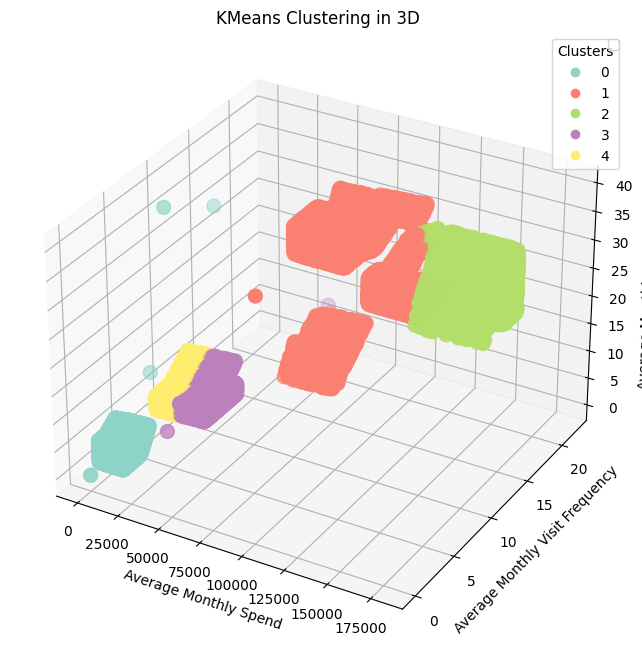

In [34]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from sklearn.cluster import DBSCAN
import seaborn as sns


# Define features for clustering
features = ['average_monthly_spend', 'average_monthly_visit_frequency', 'average_monthly_basket_size']
train_x = df_no_negatives[features]

kmeans = KMeans(n_clusters=5, random_state=42)
clusters = kmeans.fit_predict(train_x)

# Add cluster labels to the DataFrame
datasetKMeans = df_no_negatives.copy()
datasetKMeans['cluster'] = clusters

# Plotting the 3D results
fig = plt.figure(figsize=(12, 8))
ax = fig.add_subplot(111, projection='3d')

# Scatter plot for 'average_monthly_spend', 'average_monthly_visit_frequency', 'average_monthly_basket_size'
sc = ax.scatter(
    datasetKMeans['average_monthly_spend'], 
    datasetKMeans['average_monthly_visit_frequency'], 
    datasetKMeans['average_monthly_basket_size'], 
    c=datasetKMeans['cluster'], 
    cmap='Set3', 
    s=100
)

# Setting labels
ax.set_xlabel('Average Monthly Spend')
ax.set_ylabel('Average Monthly Visit Frequency')
ax.set_zlabel('Average Monthly Basket Size')
ax.set_title('KMeans Clustering in 3D')

# Creating a legend
legend1 = ax.legend(*sc.legend_elements(), title="Clusters")
ax.add_artist(legend1)
ax.legend()

plt.show()

## DBSCAN Clustering

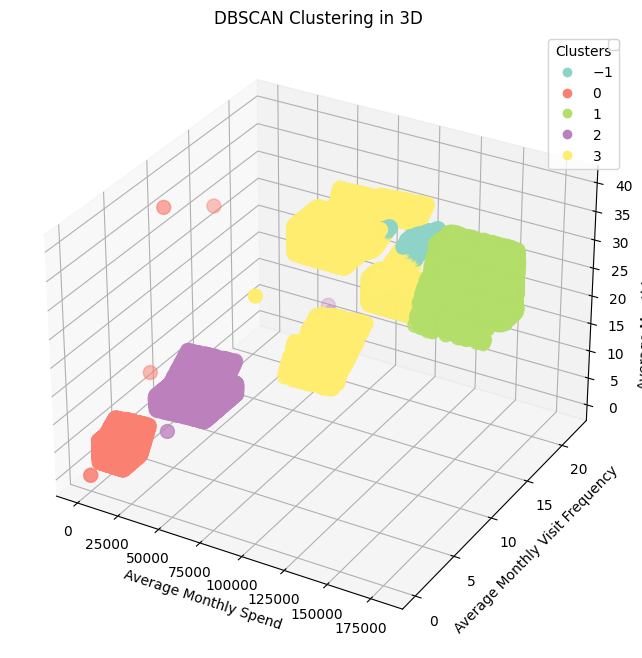

In [35]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from sklearn.cluster import DBSCAN
import seaborn as sns


# Define features for clustering
features = ['average_monthly_spend', 'average_monthly_visit_frequency', 'average_monthly_basket_size']
train_x = df_no_negatives[features]

# Apply DBSCAN algorithm
cls = DBSCAN(eps=300, min_samples=50).fit(train_x)  # Adjust the 'eps' parameter as needed
datasetDBSCAN = train_x.copy()
datasetDBSCAN.loc[:, 'cluster'] = cls.labels_

# Identify outliers
# outliers = datasetDBSCAN[datasetDBSCAN['cluster'] == -1]

# Plotting the 3D results
fig = plt.figure(figsize=(12, 8))
ax = fig.add_subplot(111, projection='3d')

# Scatter plot for 'average_monthly_spend', 'average_monthly_visit_frequency', 'average_monthly_basket_size'
sc = ax.scatter(
    datasetDBSCAN['average_monthly_spend'], 
    datasetDBSCAN['average_monthly_visit_frequency'], 
    datasetDBSCAN['average_monthly_basket_size'], 
    c=datasetDBSCAN['cluster'], 
    cmap='Set3', 
    s=100
)

# Plotting outliers
# ax.scatter(outliers['average_monthly_spend'], outliers['average_monthly_visit_frequency'], outliers['average_monthly_basket_size'], s=50, c="k", label='outliers')

# Setting labels
ax.set_xlabel('Average Monthly Spend')
ax.set_ylabel('Average Monthly Visit Frequency')
ax.set_zlabel('Average Monthly Basket Size')
ax.set_title('DBSCAN Clustering in 3D')

# Creating a legend
legend1 = ax.legend(*sc.legend_elements(), title="Clusters")
ax.add_artist(legend1)
ax.legend()

plt.show()

In [36]:
datasetDBSCAN

,average_monthly_spend,average_monthly_visit_frequency,average_monthly_basket_size,cluster
0,790.0,1.11,2.840000,0
1,176875.0,15.74,33.830000,1
2,38542.0,7.82,10.730000,2
3,48712.0,7.51,10.040000,2
4,172333.0,14.16,35.060000,1
...,...,...,...,...
566942,7287.0,1.93,5.180726,0
566943,12614.0,2.70,6.421350,0
566944,49533.0,5.87,11.835930,2
566945,95444.0,19.85,33.319614,3


In [37]:
datasetDBSCAN.to_csv("final.csv", index = False)